# Speech Transcription on IPU using Whisper - Inference

This notebook demonstrates speech transcription on the IPU using the [Whisper implementation in Hugging Face Transformers library](https://huggingface.co/spaces/openai/whisper) alongside Optimum-Graphcore.

Whisper is a versatile speech recognition model that can transcribe speech as well as perform multi-lingual translation and recognition tasks.
It was trained on diverse datasets to give human-level speech recognition performance without needing fine tuning. 

Optimum Graphcore is the interface between the Hugging Face Transformers library and [Graphcore IPUs](https://www.graphcore.ai/products/ipu).
It provides a set of tools enabling model parallelization and loading on IPUs, training and fine-tuning on all the tasks already supported by Transformers while being compatible with the Hugging Face Hub and every model available on it out of the box.

> **Hardware requirements:** The 'tiny', 'base' and 'small' Whisper models can run two replicas on the smallest IPU-Pod4 machine. The most capable model, Whisper 'large', will need to use either an IPU-POD16 or a Bow-POD16 machine. Please contact Graphcore if you'd like assistance running model sizes that don't work in this simple example notebook.

## Environment setup

In order to run this notebook you will need to be in an environment with the Poplar SDK and the Optimum-Graphcore interface to the Hugging Face Transformers library installed and enabled - on Paperspace this is handled by default. 

There are a few extra dependencies we need to handle audio.

In [1]:
# %%capture
%pip install optimum-graphcore==0.6.0
%pip install soundfile==0.12.1 librosa==0.10.0.post2 tokenizers==0.12.1
%pip install matplotlib==3.7.1
%matplotlib inline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 kB 40.2 MB/s eta 0:00:00
  Using cached transformers-4.25.1-py3-none-any.whl (5.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 52.0 MB/s eta 0:00:00
  Using cached transformers-4.27.4-py3-none-any.whl (6.8 MB)
  Using cached transformers-4.27.3-py3-none-any.whl (6.8 MB)
  Using cached transformers-4.27.2-py3-none-any.whl (6.8 MB)
  Using cached transformers-4.27.1-py3-none-any.whl (6.7 MB)
  Using cached transformers-4.27.0-py3-none-any.whl (6.8 MB)
  Using cached transformers-4.26.1-py3-none-any.whl (6.3 MB)
  Using cached transformers-4.26.0-py3-none-any.whl (6.3 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.20.1
    Uninstalling transformers-4.20.1:
      Successfully uninstalled transformers-4.20.1
  Attempt

## Running Whisper on the IPU

We first make the required imports, which include some needed to configure the IPU.


In [2]:
# Generic imports
from datasets import load_dataset
import matplotlib
import librosa
import IPython
import random

# IPU specific imports
from optimum.graphcore import IPUConfig
from optimum.graphcore.modeling_utils import to_pipelined

# HF related imports
from transformers import WhisperProcessor, WhisperForConditionalGeneration

The Whisper model is available on Hugging Face in several sizes, from 'tiny' with 39M parameters to 'large' with 1550M parameters.

We download the 'tiny' model size which we will run across two IPUs.
The [Whisper architecture](https://openai.com/research/whisper) is an encoder-decoder Transformer, with audio split into 30s chunks.
For simplicity one IPU is used for the encoder part of the graph and another for the decoder.
The `IPUConfig` object helps to configure the model to be pipelined across the IPUs.

In [ ]:
model_spec = "openai/whisper-tiny.en"

# Instantiate processor and model
processor = WhisperProcessor.from_pretrained(model_spec)
model = WhisperForConditionalGeneration.from_pretrained(model_spec)

# Adapt whisper to run on the IPU
ipu_config = IPUConfig(ipus_per_replica=2)
pipelined_model = to_pipelined(model, ipu_config)
pipelined_model = pipelined_model.parallelize(for_generation=True).half()

Now we can load the dataset and process an example audio file from it.
When the model is first run it triggers two graph compilations if precompiled models are not available.
This means that our first test transcription could take a minute or two to run, but subsequent runs will be much faster.

In [5]:
# load the dataset and read an example soundfile
ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
test_sample = ds[2]
sample_rate = test_sample['audio']['sampling_rate']

def transcribe(data, rate):
    input_features = processor(data, return_tensors="pt", sampling_rate=rate).input_features.half()

    # This triggers a compilation the first time around (unless a precompiled model is available)
    sample_output = pipelined_model.generate(input_features, max_length=448, min_length=3)
    transcription = processor.batch_decode(sample_output, skip_special_tokens=True)[0]
    return transcription

test_transcription = transcribe(test_sample["audio"]["array"], sample_rate)

Found cached dataset librispeech_asr_dummy (/tmp/huggingface_caches/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)
Graph compilation: 100%|██████████| 100/100 [00:39<00:00]


In the next cell we compare the expected text from the dataset with the transcribed text.
There will typically be some small differences, but even the 'tiny' Whisper model does a great job, and also adds in punctuation.

You can compare with the audio itself using the controls underneath.

Expected: HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMAS AND ROAST BEEF LOOMING BEFORE US SIMILES DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND

Transcribed:  He tells us that at this festive season of the year, with Christmas and roast beef looming before us, similes drawn from eating and its results occur most readily to the mind.


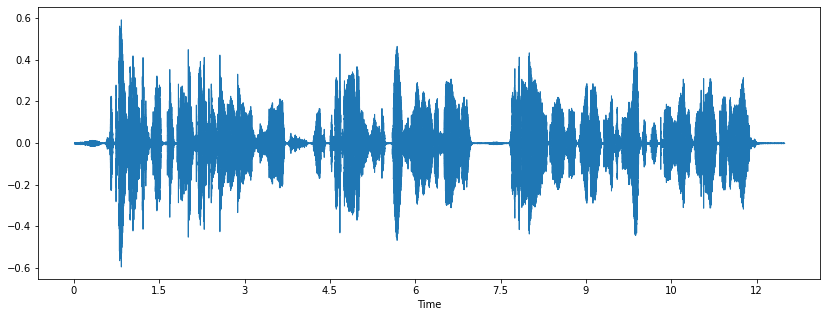

In [6]:
print(f"Expected: {test_sample['text']}\n")
print(f"Transcribed: {test_transcription}")

matplotlib.pyplot.figure(figsize=(14, 5))
librosa.display.waveshow(test_sample["audio"]["array"], sr=sample_rate)
IPython.display.Audio(test_sample["audio"]["array"], rate=sample_rate)

The model only needs to be compiled once, after which inferences will be much faster.
In the cell below we repeat the exercise but with a random example from the dataset.

You might like to re-run this next cell multiple times to get different comparisons.

Example #66

Expected: BREATHING DEEPLY BRION SOFTLY SPOKE THE AUTO HYPNOTIC PHRASES THAT TRIGGERED THE PROCESS

Transcribed:  Breathing deeply, Breon's softly spoke the other hypnotic phrases that triggered the process.


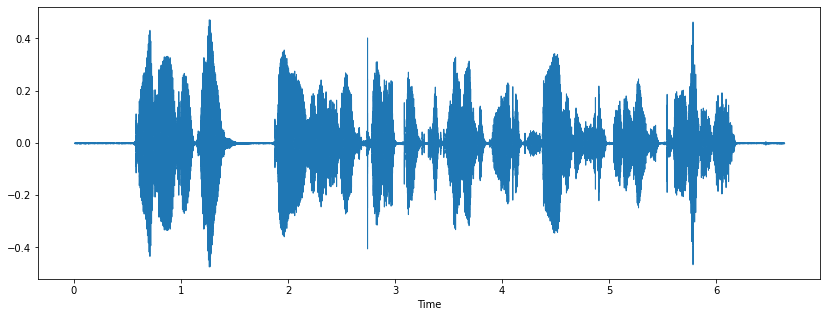

In [7]:
idx = random.randint(0, ds.num_rows - 1)
data = ds[idx]["audio"]["array"]

print(f"Example #{idx}\n")
print(f"Expected: {ds[idx]['text']}\n")
print(f"Transcribed: {transcribe(data, sample_rate)}")

matplotlib.pyplot.figure(figsize=(14, 5))
librosa.display.waveshow(data, sr=sample_rate)
IPython.display.Audio(data, rate=sample_rate, autoplay=True)

Finally we should detach the process from the IPUs when we're done with them.

In [8]:
pipelined_model.detachFromDevice()

## Next Steps

The 'tiny' model size used here is very fast for inference and so cheap to run, but its accuracy can be improved.
The 'base' and 'small' models have 74m and 244m parameters respectively (compared to just 39m for 'tiny') and can tried out by using `model_spec = "openai/whisper-base.en"` or `model_spec = "openai/whisper-small.en"` near the start of this notebook.

Larger models and multilingual models are also available.
The multilingual models (remove the `.en` from the checkpoint name) are slightly less accurate for this English transcription task but can also be used for transcribing other languages or for translating to English.

The largest models have 1550m parameters and won't fit with our simple 2 IPU pipeline.
To run these you will need more than the IPU-POD4; on Paperspace this is available using either an IPU-POD16 or a Bow-POD16 machine. Please contact Graphcore if you need assistance running these larger models.


## Conclusion

In this notebook we demonstrated using Whisper for speech recognition and transcription on the IPU.
